## Leitor de Gabarito
Alunos: Pedro Dalla e Luiz Otávio

O trabalho realiza as seguintes etapas para efetuar a leitura do gabarito:

#### Leitura e pré-processamento da imagem: 
O caminho para a imagem de entrada deve ser passado na variável IMAGE_INPUT_PATH (logo após os includes). Alguns exemplos gerados para teste podem ser encontrados na pasta 'samples'.
    - É feita a leitura da imagem.
    - Transformamos para escala de cinza.
    - Aplicamos um borramento Gaussiano para reduzir ruído e facilitar identificação das bordas.
    - Binarizamos a imagem.
#### Rotação da imagem:
Precisamos identificar uma possível rotação na imagem de entrada e desrotacioná-la se for o caso.
    - Utilizamos o detector de cantos de Canny (utilizando cv2.Canny()).
    - Com o cantos identificados, encontramos linhas na imagem (utilizando cv2.HoughLinesP).
    - Então, encontramos a maior linha (em comprimento). Sabemos que a maior linha deverá estar na vertical. Assim temos o ângulo de rotação da imagem.
    - Rotacionamos a imagem afim de deixá-la alinhada.
#### Encontrando os retângulos:
Utilizaremos os retângulos pretos da vertical e horizontal como referência.
    - Como os retângulos estão alinhados, encontramos os contornos na imagem (cv2.findContours()).
    - Comparamos os x's e y's e área dos retângulos encontrados para identificar quais dos encontrados são os retângulos pretos.
#### Identificando as marcações:
Com os retângulos encontrados combinaremos suas coordenadas para encontrar a posição de cada retângulo de resposta.
    - Utilizamos os x's dos blocos pretos das colunas com os y's dos blocos das linhas para encontrar o bloco da resposta na imagem original (sem as tranformações, apenas rotação).
    - Contamos os pixels pretos do retângulo. Caso atenda um certo limiar, consideramos-o marcado.
    - É então exibida a resposta selecionada (A até E), Branco ou Nulo, se for o caso.

In [67]:
# Imports e funções auxiliares

import math
from operator import itemgetter
import numpy as np
from matplotlib import pyplot as plt
import cv2

IMAGE_INPUT_PATH = 'data/pattern_0001_scan.png'

MAP_ANSWER = {
    0:'A',
    1:'B',
    2:'C',
    3:'D',
    4:'E'
}

# Dado uma imagem e um ângulo retorna a imagem rotacionada naquele ângulo.
def rotateImage(image, angle):
    if angle == 0.0:
        return image
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

# Filtra um array de retângulos dado uma posição e tamanho.
def rectsFilter(arr, pos, length):
    v = []
    for i, a in enumerate(arr):
        if len(v) == length:
            break
        if len(v) > 0:
            if a[pos]-15 <= v[0][pos] <= a[pos]+15:
                a_size = a[2] + a[3]
                v_size = v[0][2] + v[0][3]
                if a_size-10 <= v_size <= a_size+10:
                    v.append(a)
            else:
                del v[:]
                if a[2] + a[3] > 10:
                    v.append(a)
        else:
            if a[2] + a[3] > 10:
                v.append(a)
    return v

# Dado uma linha, retorna seu comprimento.
def getLineLength(line):
    return math.sqrt(pow(line[0] - line[2], 2) + pow(line[1] - line[3], 2))

# Dado um array de linhas, retorna a maior em comprimento.
def getLongerLine(lines):
    if len(lines) == 0:
        return
    longer = lines[0]
    for line in lines:
        longer_size = getLineLength(longer[0])
        line_size = getLineLength(line[0])
        if line_size > longer_size:
            longer = line
    
    return longer[0]

Imagem transformada para detecção dos retângulos:


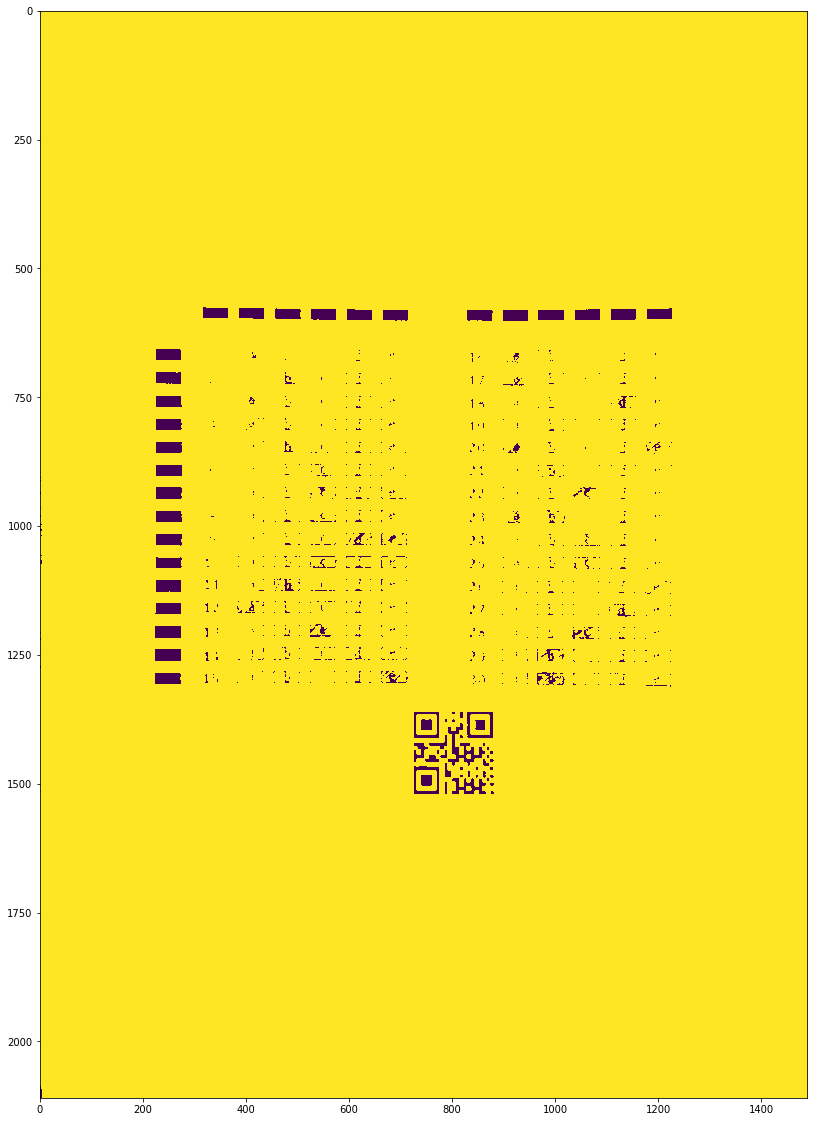

In [68]:
# Leitura e transformação da imagem.

img  = cv2.imread(IMAGE_INPUT_PATH)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)[1]

print("Imagem transformada para detecção dos retângulos:")
plt.rcParams['figure.figsize'] = [30, 20]
plt.imshow(thresh)
plt.show()

In [69]:
# Rotação da imagem.

edges = cv2.Canny(thresh, 0.1, 1)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 150, np.array([]), 50, 50)

longer_line = None

if lines is not None:
    longer_line = getLongerLine(lines)

    angle_radians = math.atan2(longer_line[3]-longer_line[1], longer_line[2]-longer_line[0])
    angle_degrees = 90 + angle_radians * (180.0/math.pi)
    print("Ângulo de rotação da imagem: " + str(angle_degrees))
    
    thresh = rotateImage(thresh, angle_degrees)
    img = rotateImage(img, angle_degrees)

Ângulo de rotação da imagem: 0.0


In [70]:
# Detecção dos retãngulos pretos de referência.

(_,contours,_) = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

rects = []
for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    rects.append([x, y, w, h])

# order by X 
rects = sorted(rects, key=lambda x: x[0])
# filter 15 rects by X
lines = rectsFilter(rects, 0, 15)
lines = sorted(lines, key=lambda x: x[1])

# order by Y
rects = sorted(rects, key=lambda x: x[1])
# filter 12 rects by Y
columns = rectsFilter(rects, 1, 12)
columns = sorted(columns, key=lambda x: x[0])

Retângulos das Linhas em Verde
Retângulos das Colunas em Azul
Linha utilizada de referência para rotação em Vermelho


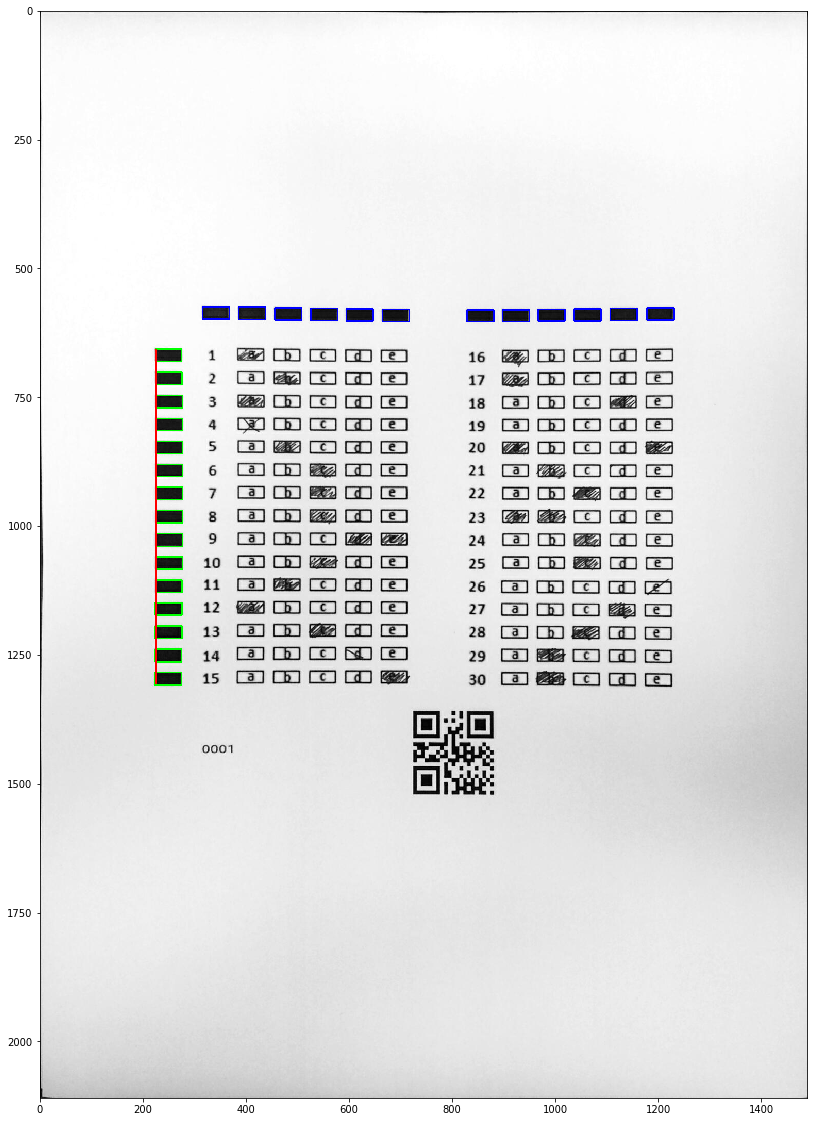

In [71]:
# Exibição dos contornos encontrados.

for v in lines:
    cv2.rectangle(img, (v[0], v[1]), (v[0]+v[2], v[1]+v[3]), (0, 255, 0), 2)
print("Retângulos das Linhas em Verde")

for h in columns:
    cv2.rectangle(img, (h[0], h[1]), (h[0]+v[2], h[1]+h[3]), (0, 0, 255), 2)
print("Retângulos das Colunas em Azul")

if longer_line is not None:
    print("Linha utilizada de referência para rotação em Vermelho")
    cv2.line(img, (longer_line[0], longer_line[1]), (longer_line[2], longer_line[3]), (255, 0, 0), 2)

plt.rcParams['figure.figsize'] = [30, 20]
plt.imshow(img)
plt.show()

In [56]:
# Leitura das respostas e exibição das respostas.

ret, img2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

for k, ranges in zip([0,1], [(1,6), (7,12)]):
    for i in range(15):
        curr_question = (i + 1) + (15 * k)
        question_opts = []
        for j in range(ranges[0], ranges[1]):
            x_begin = columns[j][0]
            x_end   = x_begin + columns[j][2]
            y_begin = lines[i][1]
            y_end   = y_begin + lines[i][3]
            answer_block = img2[y_begin:y_end, x_begin:x_end]
            filled_prop  = answer_block.mean()
            question_opts.append(filled_prop)
        
        answers_found = []

        for a,x in enumerate(question_opts):
            if x < 140:
                answers_found.append(a)
        if len(answers_found) == 1:
            print(f'{curr_question}: {MAP_ANSWER[answers_found[0]]}')
        elif len(answers_found) == 0:        
            print(f'{curr_question}: Branco')
        elif len(answers_found) > 1:
            print(f'{curr_question}: Nulo')

1: A
2: B
3: A
4: Branco
5: B
6: C
7: C
8: C
9: Nulo
10: C
11: B
12: A
13: C
14: Branco
15: E
16: A
17: A
18: D
19: Branco
20: Nulo
21: B
22: C
23: Nulo
24: C
25: C
26: Branco
27: D
28: C
29: B
30: B
